In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import time
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## **MAIN CODE to get the rating and number of votes for each album**

In [ ]:
df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv', keep_default_na=False)
start_id = df_ratings_scrapped['album_id'].iloc[-1]
start_id

517024

In [95]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import ftfy   # to fix names with unusual characters

df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv', keep_default_na=False)

album_id_list = []
artists_list = []
albums_list = []
avg_rating_list = []
number_of_votes_list = []

count = 0
scrapped = 0

start_id = df_ratings_scrapped['album_id'].iloc[-1]

for album_id in range(start_id+1,start_id+1000):
    count+=1

    if album_id in df_ratings_scrapped['album_id'].values:
        print(f'{scrapped}/{count} - id {album_id}: album already scrapped')
        continue  # Skip this album, I already have it

    url = f'https://www.sputnikmusic.com/soundoff.php?albumid={album_id}'
    response = requests.get(f"{url}")
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Extract artist and album name
    info = soup.select('table tr')
    try:
        artist = info[2].text.split('dig it')[0].split('new music')[1].split('\xa0\xa0\xa0')[0].split('\n\n\n\n\n\n\n\n\n\n')[1]
        artist_name = ftfy.fix_text(artist)
        album = info[2].text.split('dig it')[0].split('new music')[1].split('\xa0\xa0\xa0')[1]
        album_name = ftfy.fix_text(album)     # fix the name 
    except IndexError:
        print(f"{scrapped}/{count} - id {album_id}: error")
        continue  # Skip this album if the info isn't formatted as expected
    if artist_name == '':
        print(f"{scrapped}/{count} - id {album_id}: No artist found")
        continue  # Skip this album if the info isn't formatted as expected

    print(f'{scrapped}/{count} - id {album_id}: {artist_name} - {album_name}')

    # Get ratings
    rating = soup.select('font.reviewheading b')
    ratings_list = []

    for r in rating:
        if len(r.text) == 3:  # Only consider ratings with 3 characters (like "4.5")
            ratings_list.append(r.text)

    # Convert to float
    rating_floats = [float(num) for num in ratings_list]
    
    if rating_floats:
        number_of_votes = len(rating_floats) # calculate the number of votes
        number_of_votes_list.append(number_of_votes) # save it in a list

        album_id_list.append(album_id)
        artists_list.append(artist_name)
        albums_list.append(album_name)

        avg_rating = round(np.mean(rating_floats),2) # calculate the avg rating
        avg_rating_list.append(avg_rating) # save it in a list

        scrapped+=1
    else:
        print(f"{scrapped}/{count} - id {album_id}: No valid ratings found.")

0/1 - id 517025: Matavitatau - Numen Nescio (demo)
0/1 - id 517025: No valid ratings found.
0/2 - id 517026: Buzzard (USA-MA) - Mean Bone
0/2 - id 517026: No valid ratings found.
0/3 - id 517027: Muras - Początki Końca Bogów
0/3 - id 517027: No valid ratings found.
0/4 - id 517028: Muras - In Pursuit of Evil
0/4 - id 517028: No valid ratings found.
0/5 - id 517029: Mortòri - A mort l'amur
0/5 - id 517029: No valid ratings found.
0/6 - id 517030: Park Jiha - All Living Things
1/7 - id 517031: Hard Reset - 66615
2/8 - id 517032: Soundtrack (Video Game) - Twisted Metal: Black
3/9 - id 517033: Truman Sinclair - American Recordings
4/10 - id 517034: Morkvind - Versunkenes Reich
4/10 - id 517034: No valid ratings found.
4/11 - id 517035: Thin - The Overlapping Nature of Things
4/11 - id 517035: No valid ratings found.
4/12 - id 517036: Jeff van Dyck - Shogun II: Total War OST
5/13 - id 517037: Cult Member (CAN) - Ethernet
6/14 - id 517038: Siniestra Maria - Poetas De Un Mundo Muerto
7/15 - i

In [96]:
(9.5*60)/1000

0.57

## **Saving the data**

In [97]:
lists = [('album_id', album_id_list)
        , ('artists', artists_list)
         , ('albums', albums_list)
         , ('avg_rating', avg_rating_list)
         , ('number_of_votes', number_of_votes_list)
         ]

for name, lst in lists:
    print(f'{name}: {len(lst)}') # check that all lists have the same length (even though I had make sure with the previous code)

album_id: 26
artists: 26
albums: 26
avg_rating: 26
number_of_votes: 26


In [98]:
# the new df with the artists I just scrapped
data = pd.DataFrame({'album_id': album_id_list
                    , 'artist': artists_list
                    , 'album': albums_list
                    , 'rating': avg_rating_list
                    , 'votes': number_of_votes_list})
print(f'{data.shape[0]} releases\n{data.artist.nunique()} different artists')

26 releases
22 different artists


In [99]:
print(f'I could webscrap {round(scrapped / count*100, 2)}% of the albums\n{scrapped} of {count} total albums')

I could webscrap 2.6% of the albums
26 of 999 total albums


In [100]:
print(f'{data[data['votes']<10].shape[0]} albums with < 10 votes, meaning {round((data[data['votes']<10].shape[0] / data.shape[0])*100,2)}% of the albums')
print(f'{data[data['votes']>10].shape[0]} of {data.shape[0]} actual valid albums')

26 albums with < 10 votes, meaning 100.0% of the albums
0 of 26 actual valid albums


In [101]:
# most voted albums
data.sort_values('votes', ascending=False).head(10)

,album_id,artist,album,rating,votes
0,517030,Park Jiha,All Living Things,3.88,5
1,517031,Hard Reset,66615,3.50,1
24,517078,Edge of Sanity,The Spectral Sorrows (Remix 2024),4.50,1
23,517077,"Stian Larsen, Colin Webster, Ruth Goller and A...",Temple of Muses,3.50,1
22,517076,Stereocilia,Phases,3.50,1
21,517075,Star House (USA),Versions From Our Future (Our Past),3.50,1
20,517074,Thala,Avalanche,3.00,1
19,517071,Philippe Manoury,Synapse,4.00,1
18,517070,Philipp Heinrich Erlebach,Wer sind diese mit weißen Kleidern angetan,4.00,1
17,517068,Philipp Heinrich Erlebach,"Unruhige Gedanken, stellt alles Sorgen ein",4.00,1


In [102]:
# top rated albums 
data[data['votes']>100].sort_values('rating', ascending=False).head(10)

,album_id,artist,album,rating,votes


In [86]:
# plt.figure(figsize=(6,9))
# sns.countplot(data=data, y='votes')

## Concat with the df of the ratings previously scrapped

In [ ]:
df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv', keep_default_na=False)
df_ratings_scrapped.shape

(352744, 5)

In [104]:
df_ratings = pd.concat([df_ratings_scrapped, data])
df_ratings.reset_index(drop=True, inplace=True)
df_ratings.shape

(352770, 5)

In [105]:
print(f'{df_ratings.shape[0]} albums\n{df_ratings.artist.nunique()} different artists')

352770 albums
131115 different artists


In [106]:
min_votes = 20

print(f'{round((df_ratings[df_ratings['votes']<min_votes].shape[0] / df_ratings.shape[0])*100,2)}% of the albums have less than {min_votes} votes')

85.47% of the albums have less than 20 votes


## **Exporting to csv (and importing in case needed)**

In [107]:
df_ratings.to_csv('Datasets/df_ratings.csv', index=False)

In [2]:
# in case I have to import it again
df_ratings = pd.read_csv('Datasets/df_ratings.csv', keep_default_na=False)

## **Handling null values**

In [152]:
df_ratings['album'].isna().sum()

99

In [151]:
df_ratings[df_ratings['album'].isna()].sort_values('votes').tail(10)

,album_id,artist,album,rating,votes
223673,302982,Stratovarius,NaN,3.75,2
239670,326601,The Circle of Tyrants,NaN,3.5,3
165284,215723,Soundtrack (Film),NaN,4.17,3
26549,32591,The Hollies,NaN,4.17,3
200477,265451,Autumn (NLD),NaN,3.83,3
94610,117169,Big Dunstin,NaN,5.0,3
297699,418248,Knoll/Autolith,NaN,3.38,4
77292,94802,Arms of Ra,NaN,3.75,4
236586,321880,The Ansible,NaN,3.25,4
258373,353796,Nito,NaN,4.25,4


In [111]:
df_ratings.shape

(352770, 5)

In [150]:
# drop the NaN albums that are no standard albums: compilations, lives...
df_ratings.drop([54526], inplace=True)

df_ratings.shape

(352768, 5)

In [128]:
# replace the null values for the actual name of the album
df_ratings['album'] = np.where(df_ratings['album_id']==35979, 'None', df_ratings['album'])
df_ratings['album'] = np.where(df_ratings['album_id']==348119, 'None', df_ratings['album'])
df_ratings['album'] = np.where(df_ratings['album_id']==44314, 'Vom Bordstein bis zur Skyline', df_ratings['album'])
df_ratings['album'] = np.where(df_ratings['album_id']==32154, "You Don't Deserve the Air in Your Lungs", df_ratings['album'])
df_ratings['album'] = np.where(df_ratings['album_id']==77369, 'The Only Color That Matters Is Green', df_ratings['album'])
df_ratings['album'] = np.where(df_ratings['album_id']==209225, '#N/A', df_ratings['album'])
df_ratings['album'] = np.where(df_ratings['album_id']==138232, 'Keeping The Nite Light Burning', df_ratings['album'])

df_ratings['album'].isna().sum()

100

In [153]:
df_ratings.to_csv('Datasets/df_ratings.csv', index=False)

## **Statistics**

**Top rated albums**

In [5]:
df_ratings.sort_values(['rating', 'votes'], ascending=False).query('votes>10').head(25)

,album_id,artist,title,rating,votes
117737,148238,Strapping Young Lad,The Complete Works,4.96,13
116715,146751,Mr. Bungle,The Studio Album Collection,4.92,25
163114,212538,Dir En Grey,Dum Spiro Spero At Nippon Budokan,4.89,14
55769,68365,The Seatbelts,Cowboy Bebop Boxed Set,4.87,19
328239,469642,The Replacements,Tim (Let It Bleed Edition),4.86,11
53354,65416,Cardiacs,The Special Garage Concerts Vol I,4.85,13
124082,156669,Darkhaus,My Only Shelter,4.82,11
42178,51391,The Who,Live At The Filmore East,4.81,16
64125,78423,The Beatles,The Beatles In Mono,4.80,40
4939,6768,Lynyrd Skynyrd,Lynyrd Skynyrd (Box Set),4.80,15


**Most voted albums**

In [153]:
df_ratings.sort_values('votes', ascending=False).head(5)

,album_id,artist,album,rating,votes
1249,1484,Radiohead,OK Computer,4.54,9186
59,116,Metallica,Master Of Puppets,4.45,8950
69,130,Pink Floyd,The Dark Side Of The Moon,4.55,8048
148,222,Metallica,Ride The Lightning,4.42,8013
152,226,Radiohead,Kid A,4.43,7685


In [154]:
df_ratings.artist.value_counts().head(10)

artist
Bull Of Heaven             367
Buckethead                 285
Soundtrack (Film)          248
Various Artists            247
John Zorn                  102
Psychic TV                  92
Soundtrack (Video Game)     84
Miles Davis                 82
Frank Zappa                 81
Johnny Cash                 80
Name: count, dtype: int64

In [154]:
df_ratings[df_ratings['artist']=='King Gizzard and The Lizard Wizard'].sort_values('rating', ascending=False)

,album_id,artist,album,rating,votes
316408,448256,King Gizzard and The Lizard Wizard,Live at Red Rocks '22,4.76,33
349897,511439,King Gizzard and The Lizard Wizard,Live in Albuquerque '24,4.75,2
348799,509042,King Gizzard and The Lizard Wizard,Live at Red Rocks '24,4.75,2
327143,467718,King Gizzard and The Lizard Wizard,Live in Chicago '23,4.55,11
349015,509339,King Gizzard and The Lizard Wizard,Live in Los Angeles '24,4.5,1
...,...,...,...,...,...
257200,351860,King Gizzard and The Lizard Wizard,Sleep/ Summer,3.0,5
327144,467719,King Gizzard and The Lizard Wizard,Demos Vol. 5 + Vol. 6,3.0,2
171170,223888,King Gizzard and The Lizard Wizard,Hey There/Ants & Bats,2.96,14
114598,143937,King Gizzard and The Lizard Wizard,Eyes Like The Sky,2.96,162


In [79]:
df_ratings[df_ratings['artist']=='Various Artists']

,album_id,artist,album,rating,votes
2405,3667,Various Artists,Music as a Weapon II,3.03,85
8166,15291,Various Artists,A Christmas Gift For You,3.82,50
11700,23878,Various Artists,No New York,4.11,68
20808,65942,Various Artists,Whom The Moon A Nightsong Sings,3.87,32
28227,155742,Various Artists,Let No One Judge You: Early Recordings from Iran,3.25,2
...,...,...,...,...,...
131718,96984,Various Artists,Punk Goes Pop 4,2.15,17
133981,100142,Various Artists,Elect-Lo-Nica Compilation,1.50,1
135115,101704,Various Artists,New Orleans -The Original Sound of Funk 1960-1975,3.00,1
136753,154131,Various Artists,"100 Moons: Hindustani Vocal Art, 1930-55",3.50,2


In [81]:
df_ratings[df_ratings['artist']=='Soundtrack (Film)']

,album_id,artist,album,rating,votes
5954,10169,Soundtrack (Film),South Park (Original Soundtrack),3.93,64
6021,10302,Soundtrack (Film),Pulp Fiction,3.88,85
6204,10653,Soundtrack (Film),Team America: World Police,3.97,38
6541,11286,Soundtrack (Film),The Crow,3.91,44
9511,18273,Soundtrack (Film),Garden State,3.75,46
...,...,...,...,...,...
132281,97757,Soundtrack (Film),The Hunger Games,3.17,21
133099,98837,Soundtrack (Film),Collateral,2.88,4
135567,102385,Soundtrack (Film),Ma 6-T Va Cracker,4.00,1
136583,103895,Soundtrack (Film),Fight Club,3.93,14


In [89]:
df_ratings['votes'].value_counts().head(15)

votes
1     28632
2     15339
3     10239
4      7320
5      5863
6      4645
7      3920
8      3272
9      2806
10     2442
11     2251
12     2035
13     1750
14     1555
15     1406
Name: count, dtype: int64

<Axes: xlabel='votes', ylabel='Count'>

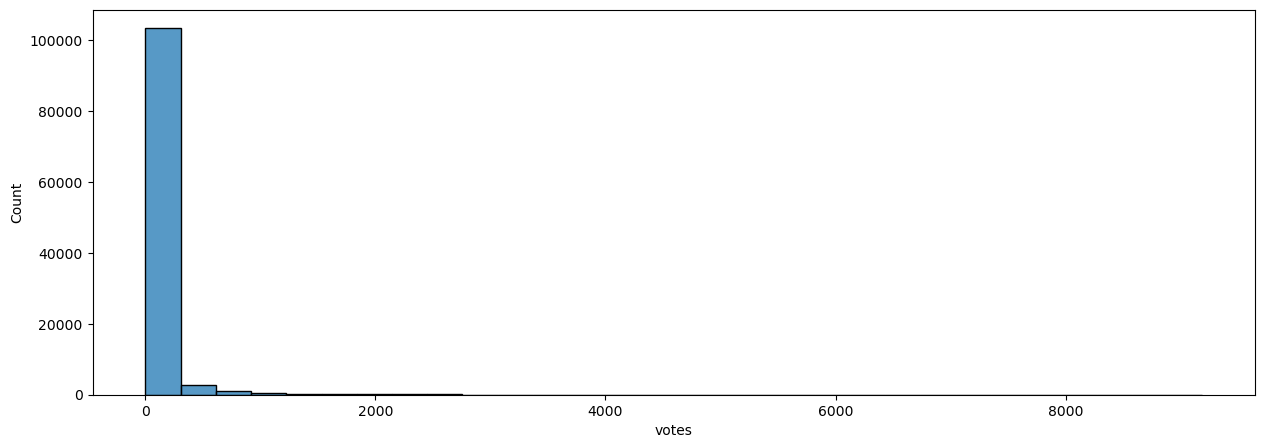

In [86]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_ratings[df_ratings['votes']>1], x='votes', bins=30)

In [87]:
df_ratings.shape

(137202, 5)